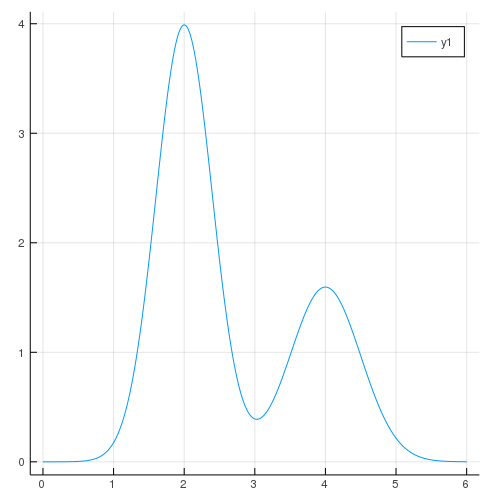

In [1]:
include("../src/StatReg.jl")
using .StatReg
using Plots
plotly()
gr(size=(500,500), html_output_format=:png)
using QuadGK

a = 0
b = 6.

function phi(x::Real)
    mu1 = 2.
    mu2 = 4.
    n1 = 4.
    n2 = 2.
    sig1 = 0.4
    sig2 = 0.5
    norm(n, mu, sig, x) = n / sqrt(2 * pi*sig^2) * exp(-(x - mu)^2 / (2 * sig^2))
    return norm(n1, mu1, sig1, x) + norm(n2, mu2, sig2, x)
end

x = collect(range(a, stop=b, length=300))

myplot = plot(x, phi.(x))

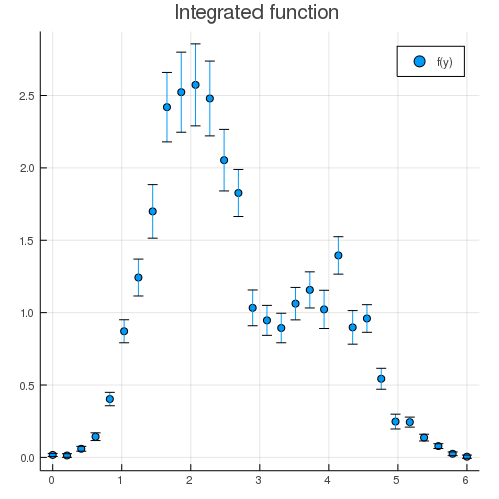

In [2]:
using QuadGK

kernel(x::Real, y::Real) = getOpticsKernels("gaussian")(x, y)

convolution = y -> quadgk(x -> kernel(x,y) * phi(x), a, b, rtol=10^-5, maxevals=10^7)[1]
y = collect(range(a, stop=b, length=30))
ftrue = convolution.(y)

sig = 0.1*ftrue + [0.01 for i = 1:Base.length(ftrue)]

using Compat, Random, Distributions
noise = []
Random.seed!(1234)
for sigma in sig
    n = rand(Normal(0., sigma), 1)[1]
    push!(noise, n)
end

f = ftrue + noise

plot(y, f, title="Integrated function",label=["f(y)"],seriestype=:scatter, yerr=sig)
# savefig("integrated.png")

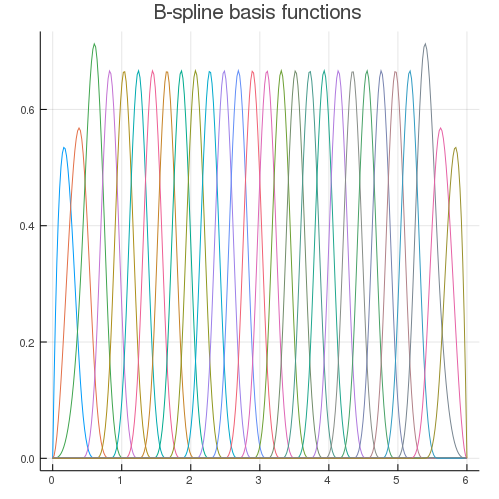

┌ Info: Cubic spline basis is created.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:246


In [3]:
basis = CubicSplineBasis(y, "dirichlet")
p = plot()
for func in basis.basis_functions
    p = plot!(x, func.f.(x), title="B-spline basis functions", legend=false, show = true)
end
display(p)
# savefig("basis.png")

In [4]:
kernel_matrix = discretize_kernel(basis, kernel, y)
Omega = omega(basis, 2)
model = MCMCMatrixUnfolder([Omega], "EmpiricalBayes"; alphas=nothing, lower=[1e-8], higher=[10.], initial=[0.3])
println()

┌ Info: Starting discretize kernel...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:45
┌ Info: Kernel was discretized successfully.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:56
┌ Info: Calculating omega matrix for Cubis spline basis derivatives of order 2...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:267
┌ Info: Omega caclulated successfully.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:285


┌ Info: MCMCMatrixUnfolder is created.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/mcmc.jl:56


In [7]:
using Mamba
args = solve(model, kernel_matrix, f, sig)
sim = mcmc(args[1]...; args[2]...)
result = get_values(sim)
println()

Iter     Function value   Gradient norm 
     0    -2.294659e+02     4.262323e+00
     1    -2.317263e+02     1.156675e+00
     2    -2.319297e+02     4.784070e-03
     3    -2.319297e+02     2.480956e-08
     4    -2.319297e+02     8.931443e-09


┌ Info: Starting solve...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/mcmc.jl:106
┌ Info: Starting find_optimal_alpha...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/check.jl:122
┌ Info: Starting optimization...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/check.jl:147
┌ Info: Optimized successfully, alphas = [0.0939681].
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/check.jl:162
┌ Info: Ending solve...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/mcmc.jl:122
┌ Info: Starting solve_MCMC...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/mcmc.jl:141
┌ Info: Ending solve_MCMC...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/mcmc.jl:175


┌ Info: PhiVec is created.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/StatReg.jl/src/vector.jl:64


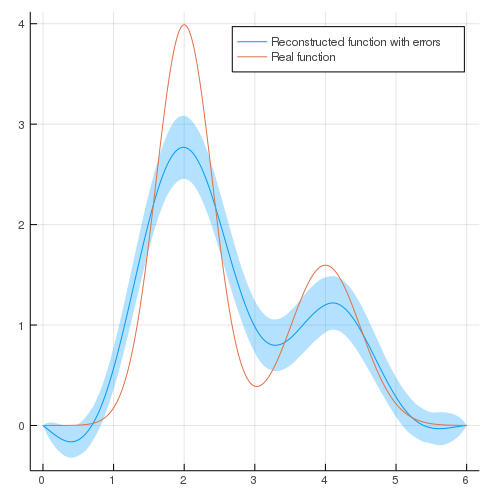

In [8]:
phivec = PhiVec(result, basis)

phi_reconstructed = phivec.phi_function.(x)
phi_reconstructed_errors = phivec.error_function.(x)

plot(x, phi_reconstructed, ribbon=phi_reconstructed_errors, fillalpha=0.3, label="Reconstructed function with errors")
plot!(x, phi.(x), label="Real function")
# savefig("reconstructed.png")